# Cellular automata

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

## Zero-dimensional CA

Here's a simple implementation of the 0-D CA I mentioned in the book, with one cell.

In [2]:
n = 10
x = np.zeros(n)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


To get the state of the cell in the next time step, we increment the current state mod 2.

In [3]:
x[1] = (x[0] + 1) % 2
x[1]

1.0

Filling in the rest of the array.

In [4]:
for i in range(2, n):
    x[i] = (x[i-1] + 1) % 2
    
print(x)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


So the behavior of this CA is simple: it blinks.

## One-dimensional CA

In [5]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


To plot the array I use `plt.imshow`

In [6]:
def plot_ca(array):
    plt.imshow(array, cmap='Blues', interpolation='none')

Here's what it looks like after we initialize the first row.

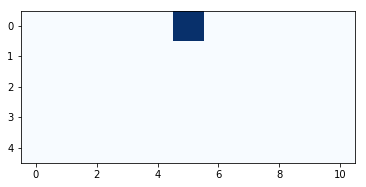

In [7]:
plot_ca(array)

And here's the function that fills in the next row.  The rule for this CA is to take the sum of a cell and its two neighbors mod 2.

In [8]:
def step(array, i):
    """Compute row i of a CA.
    """
    rows, cols = array.shape
    row = array[i-1]
    for j in range(1, cols):
        elts = row[j-1:j+2]
        array[i, j] = sum(elts) % 2

Here's the second row.

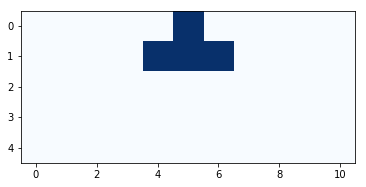

In [9]:
step(array, 1)
plot_ca(array)

And here's what it looks like with the rest of the cells filled in.

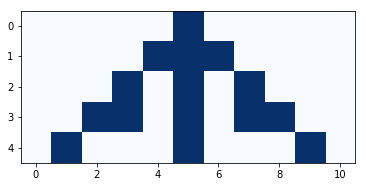

In [10]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

For a simple set of rules, the behavior is more interesting than you might expect.

**Exercise:** Modify this code to increase the number of rows and columns and see what this CA does after more time steps.

In [11]:
rows = 10
cols = 25
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 12] = 1

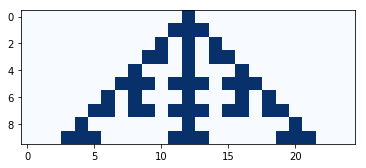

In [12]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

## Cross correlation

We can update the CA more quickly using "cross correlation".  The cross correlation of an array, `a`, with a window, `w`, is a new array, `c`, where element `k` is:

$ c_k = \sum_{n=0}^{N-1} a_{n+k} \cdot w_n $

In Python, we can compute element `k` like this:

In [13]:
def c_k(a, w, k):
    """Compute element k of the cross correlation of a and w.
    """
    N = len(w)
    return sum(a[k:k+N] * w)

To see how this works, I'll create an array:

In [14]:
N = 10
row = np.arange(N, dtype=np.uint8)
print(row)

[0 1 2 3 4 5 6 7 8 9]


And a window:

In [15]:
window = [1, 1, 1]

print(window)

[1, 1, 1]


With this window, each element of `c` is the sum of three neighbors in the array:

In [16]:
c_k(row, window, 0)

3

In [17]:
c_k(row, window, 1)

6

The following function computes the elements of `c` for all values of `k` where the window can overlap with the array:

In [18]:
def correlate(row, window):
    """Compute the cross correlation of a and w.
    """
    cols = len(row)
    N = len(window)
    c = [c_k(row, window, k) for k in range(cols-N+1)]
    return np.array(c)

In [19]:
c = correlate(row, window)
print(c)

[ 3  6  9 12 15 18 21 24]


This operation is useful in many domains, so libraries like NumPy usually provide an implementation.  Here's the version from NumPy.

In [20]:
c = np.correlate(row, window, mode='valid')
print(c)

[ 3  6  9 12 15 18 21 24]


With `mode='valid'`, the NumPy version does the same thing as mine: it only computes the elements of `c` where the window overlaps with the array.  A drawback of this mode is that the result is smaller than `array`.

And alternative is `mode='same'`, which makes the result the same size as `array` by extending array with zeros on both sides.  Here's the result:

In [21]:
c = np.correlate(row, window, mode='same')
print(c)

[ 1  3  6  9 12 15 18 21 24 17]


**Exercise:** Write a version of `correlate` that returns the same result as `np.correlate` with `mode='same'.`

In [22]:
# Hint: use np.pad to add zeros at the beginning and end of `row`
def correlate_same(row, window):
    """Compute the cross correlation of a and w.
    """
    row_same = np.pad(row,1,'constant')
    cols = len(row_same)
    N = len(window)
    c = [c_k(row_same, window, k) for k in range(cols-N+1)]
    return np.array(c)
c = correlate_same(row,window)
print(c)

[ 1  3  6  9 12 15 18 21 24 17]


## Update with correlate

Now we can use `np.correlate` to update the array.  I'll start again with an array that contains one column for each cell and one row for each time step, and I'll initialize the first row with a single "on" cell in the middle:

In [23]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


Now here's a version of `step` that uses `np.correlate`

In [24]:
def step2(array, i, window=[1,1,1]):
    """Compute row i of a CA.
    """
    row = array[i-1]
    c = np.correlate(row, window, mode='same')
    array[i] = c % 2

And the result is the same.

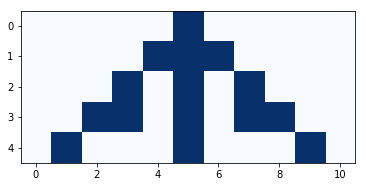

In [25]:
for i in range(1, rows):
    step2(array, i)

plot_ca(array)

## CA Tables

What we have so far is good enough for a CA that only depends on the total number of "on" cells, but for more general CAs, we need a table that maps from the configuration of the neighborhood to the future state of the center cell.

The following function makes the table by interpreting the Rule number in binary.

In [26]:
def make_table(rule):
    """Make the table for a given CA rule.
    
    rule: int 0-255
    
    returns: array of 8 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table

Here's what it looks like as an array:

In [27]:
table = make_table(150)
print(table)

[0 1 1 0 1 0 0 1]


If we correlate the row with the window `[4, 2, 1]`, it treats each neighborhood as a binary number between 000 and 111.

In [28]:
window = [4, 2, 1]
c = np.correlate(array[0], window, mode='same')
print(array[0])
print(c)

[0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 2 4 0 0 0 0]


Now we can use the result from `np.correlate` as an index into the table; the result is the next row of the array.

In [29]:
array[1] = table[c]
print(array[1])

[0 0 0 0 1 1 1 0 0 0 0]


We can wrap up that code in a function:

In [30]:
def step3(array, i, window=[4,2,1]):
    """Compute row i of a CA.
    """
    row = array[i-1]
    c = np.correlate(row, window, mode='same')
    array[i] = table[c]

And test it again.

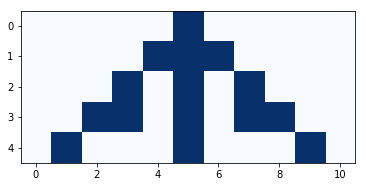

In [31]:
for i in range(1, rows):
    step3(array, i)

plot_ca(array)

How did I know that Rule 150 is the same as the previous CA?  I wrote out the table and converted it to binary.

## The Cell1D object

`Cell1D` encapsulates the code from the previous section.

In [32]:
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, m=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.random(self.m).round()
        self.next += 1

    def start_string(self, s):
        """Start with values from a string of 1s and 0s."""
        # TODO: Check string length
        self.array[0] = np.array([int(x) for x in s])
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.array[:, start:end]
        plt.imshow(a, cmap='Blues', alpha=0.7)
        
        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])

The following function makes and draws a CA.

In [33]:
def draw_ca(rule, n=32):
    """Makes and draw a 1D CA with a given rule.
    
    rule: int rule number
    n: number of rows
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    ca.loop(n-1)
    ca.draw()

Here's an example that runs a Rule 50 CA for 10 steps.

Saving figure to file figs/chap05-1


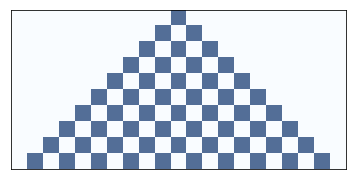

In [34]:
draw_ca(rule=50, n=10)
savefig('figs/chap05-1')

Another example:

Saving figure to file figs/chap05-2


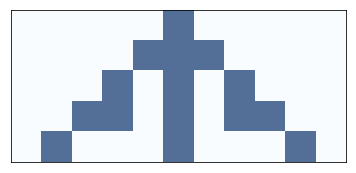

In [35]:
draw_ca(rule=150, n=5)

savefig('figs/chap05-2')

And one more example showing recursive structure.

Saving figure to file figs/chap05-3


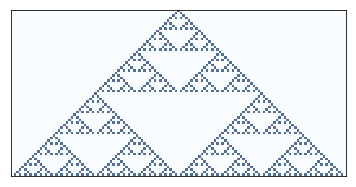

In [36]:
draw_ca(rule=18, n=64)

savefig('figs/chap05-3')

Rule 30 generates a sequence of bits that is indistinguishable from random:

Saving figure to file figs/chap05-4


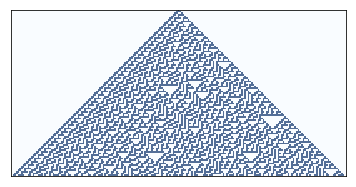

In [37]:
draw_ca(rule=30, n=100)

savefig('figs/chap05-4')

And Rule 110 is Turing complete!

Saving figure to file figs/chap05-5


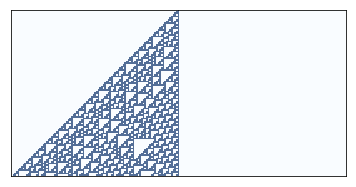

In [38]:
draw_ca(rule=110, n=100)

savefig('figs/chap05-5')

Here's a longer run that has some spaceships.

Saving figure to file figs/chap05-6


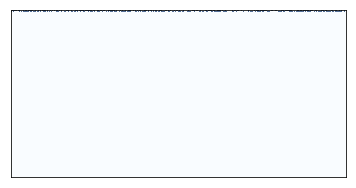

In [39]:
np.random.seed(21)
ca = Cell1D(rule=110, n=600)
ca.start_random()
ca.loop(n-1)
ca.draw()

savefig('figs/chap05-6')

## Exercises

**Exercise:** This exercise asks you to experiment with Rule 110 and see how
many spaceships you can find.

1. Read the [Wikipedia page about Rule 110](https://en.wikipedia.org/wiki/Rule_110), which describes its background pattern and spaceships.

2. Create a Rule 110 CA with an initial condition that yields the
  stable background pattern.  Note that the CA class provides
`start_string`, which allow you to initialize the state of
the array using a string of `1`s and `0`s.

3. Modify the initial condition by adding different patterns in the
  center of the row and see which ones yield spaceships.  You might
  want to enumerate all possible patterns of $n$ bits, for some
  reasonable value of $n$.  For each spaceship, can you find the
  period and rate of translation?  What is the biggest spaceship you
  can find?

4. What happens when spaceships collide?

In [40]:
def draw_ca_mod(rule,n,s):
    """Makes and draw a 1D CA with a given rule.
    
    rule: int rule number
    n: number of rows
    """
    ca = Cell1D(rule, n)
    number = int((((n*2)+1) - len(s))/2)
    s_new = np.pad(list(s),number,'constant')
    if len(s_new)%2 == 0:
        s_new = np.append(s_new,'0')
    ca.start_string(s_new)
    ca.loop(n-1)
    ca.draw()

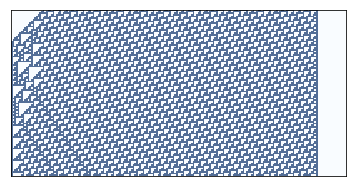

In [50]:
draw_ca_mod(110,100,'00010011011111'*12) #draws with stable background pattern

In [135]:
def add_spaceship(s,k_p):
    middle = int(len(s)/2)
    k_s = s[:middle] + k_p + s[middle:]
    return k_s   

In [144]:
def generate_numbers():
    k_s = []
    for i in range(8):
        k_p = "{0:03b}".format(i)
        k_s.append(k_p)
    print(k_s)
    return k_s

['000', '001', '010', '011', '100', '101', '110', '111']
000


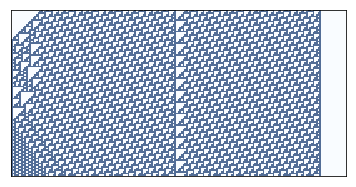

In [149]:
numbers = generate_numbers()
print(numbers[0])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[0]))

001


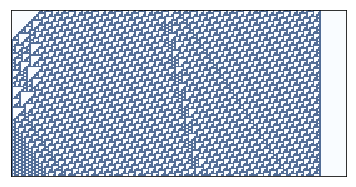

In [150]:
print(numbers[1])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[1]))

010


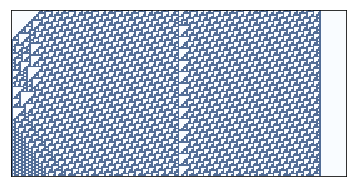

In [151]:
print(numbers[2])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[2]))

011


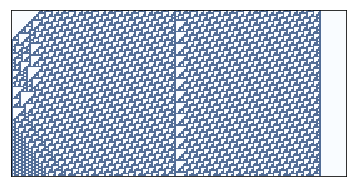

In [152]:
print(numbers[3])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[3]))

100


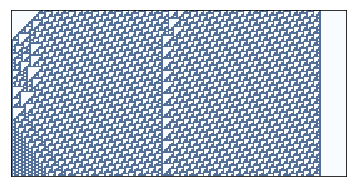

In [153]:
print(numbers[4])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[4]))

101


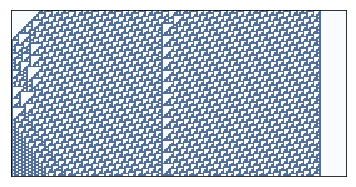

In [154]:
print(numbers[5])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[5]))

110


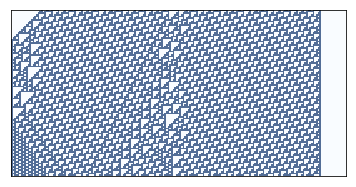

In [155]:
print(numbers[6])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[6]))

111


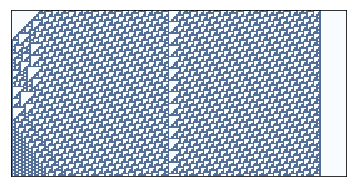

In [156]:
print(numbers[7])
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,numbers[7]))

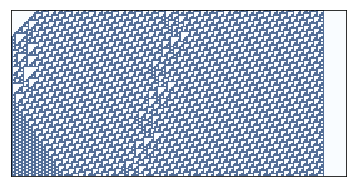

In [157]:
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,'1001111')) #This is another pattern with spaceships


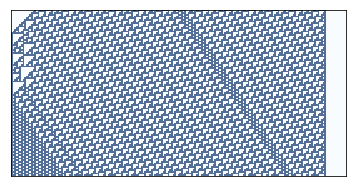

In [158]:
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,'0001110111')) #This pattern also has spaceships

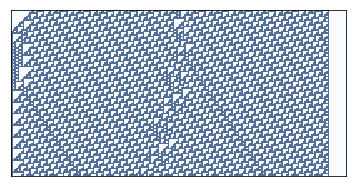

In [164]:
draw_ca_mod(110,100,add_spaceship('00010011011111'*12,'0001110111'+'111')) #collision of the two possibly?

When spaceships collide, they collide to form a new pattern that is a combination of the two that collide.

**Exercise:** The goal of this exercise is to implement a Turing machine.

1. Read about Turing machines at http://en.wikipedia.org/wiki/Turing_machine.

2. Write a class called `Turing` that implements a Turing machine.  For the action table, use the rules for a 3-state busy beaver.

3. Write a `draw` method that plots the state of the tape and the position and state of the head.  For one example of what that might look like, see http://mathworld.wolfram.com/TuringMachine.html.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise:** This exercise asks you to implement and test several PRNGs.
For testing, you will need to install 
`DieHarder`, which you can download from 
https://www.phy.duke.edu/~rgb/General/dieharder.php, or it
might be available as a package for your operating system.

1. Write a program that implements one of the linear congruential
generators described at http://en.wikipedia.org/wiki/Linear_congruential_generator}.
Test it using `DieHarder`.

2. Read the documentation of Python's `random` module.
What PRNG does it use?  Test it.

3. Implement a Rule 30 CA with a few hundred cells,
run it for as many time steps as you can in a reasonable amount
of time, and output the center column as a sequence of bits.
Test it.


In [ ]:
def lcg(mod,a,seed,c):
    

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here